In [1]:
import random
from operator import add
from pprint import pprint
from IPython.display import Image, display

from typing_extensions import Any
from typing_extensions import List
from typing_extensions import Dict
from typing_extensions import Tuple
from typing_extensions import Union
from typing_extensions import Literal
from typing_extensions import Sequence
from typing_extensions import Annotated
from typing_extensions import TypedDict

from langgraph.graph import START
from langgraph.graph import END
from langgraph.graph import StateGraph
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from langgraph.managed import IsLastStep
from langgraph.managed import RemainingSteps

from langchain_core.messages import AIMessage
from langchain_core.messages import AnyMessage
from langchain_core.messages import BaseMessage
from langchain_core.messages import HumanMessage

from langgraph.checkpoint.memory import MemorySaver

In [104]:
# MODEL 1

class InputState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

class OverallState(TypedDict):
    next_step: str
    # messages: Annotated[list[AnyMessage], add_messages]  # Default `messages` dari MessageState
    messages: Annotated[Sequence[BaseMessage], add_messages]  # Default `messages` dari create_react_agent
    steps: Annotated[List[str], add]  # History daftar step yang dilalui
    llm_usage_metadata: Annotated[List[Dict[str, Union[str, Dict[str, Any]]]], add]  # History LLM dan token usage
    
    # is_last_step: IsLastStep  # Nanti kodingan create_react_agent yang implementasi (otomatis ditambahkan)
    # remaining_steps: RemainingSteps  # Nanti kodingan create_react_agent yang implementasi (otomatis ditambahkan)

class OutputState(TypedDict):
    # output: AIMessage  # Ternyata jangan pakai nama `messages lagi`
    # messages: Annotated[list[AnyMessage], add_messages]
    messages: Annotated[Sequence[BaseMessage], add_messages]
    steps: Annotated[List[str], add]
    llm_usage_metadata: Annotated[List[Dict[str, Union[str, Dict[str, Any]]]], add]

In [ ]:
# Model 1

def guardrails(
    state: InputState
) -> OverallState:
    return {
        "next_step": "planner" if random.random() > 0.2 else "final_answer",
        "messages": [AIMessage("[Guardrails]: OK")],
        "steps": [START] + ["guardrails"],
        "llm_usage_metadata": [{
            "id": "run-2b100f1a-f169-47cd-b043-851d605b4264-0",
            "step": "guardrails",
            "model": "gemini-2.0-flash",
            "tokens": {
                "input_tokens": 2207,
                "output_tokens": 57,
                "total_tokens": 2264,
                "input_token_details": {"cache_read": 0}
            }
        }]
    }

def planner(
    state: OverallState
) -> OverallState:
    return {
        "next_step": "agent",
        "messages": [AIMessage("[Planner]: OK")],
        "steps": ["planner"],
        "llm_usage_metadata": [{
            "id": "run-2b100f1a-f169-47cd-b043-851d605b4264-0",
            "step": "guardrails",
            "model": "gemini-2.0-flash",
            "tokens": {
                "input_tokens": 2207,
                "output_tokens": 57,
                "total_tokens": 2264,
                "input_token_details": {"cache_read": 0}
            }
        }]
    }

def agent(
    state: OverallState
) -> OverallState:
    return {
        "next_step": "tools" if random.random() > 0.5 else "final_answer",
        "messages": [AIMessage("[Agent]: OK")],
        "steps": ["agent"],
        "llm_usage_metadata": [{
            "id": "run-2b100f1a-f169-47cd-b043-851d605b4264-0",
            "step": "guardrails",
            "model": "gemini-2.0-flash",
            "tokens": {
                "input_tokens": 2207,
                "output_tokens": 57,
                "total_tokens": 2264,
                "input_token_details": {"cache_read": 0}
            }
        }]
    }

def tools(
    state: OverallState
) -> OverallState:
    return {
        "next_step": "agent",
        "messages": [AIMessage("[Tools]: OK")],
        "steps": ["tools"],
        "llm_usage_metadata": [(
            "tools", {
                "input_tokens": 2207,
                "output_tokens": 57,
                "total_tokens": 2264,
                "input_token_details": {"cache_read": 0}
            }
        )]
    }

def final_answer(
    state: OverallState
) -> OutputState:
    return {
        # "output": AIMessage("[final_answer]: OK"),
        "messages": [AIMessage("[final_answer]: OK")],
        "steps": ["final_answer"] + [END],
        "llm_usage_metadata": [(
            "final_answer", {
                "input_tokens": 2207,
                "output_tokens": 57,
                "total_tokens": 2264,
                "input_token_details": {"cache_read": 0}
            }
        )]
    }

def guardrails_cond_edge(
    state: OverallState
) -> Literal["planner", "final_answer"]:
    match state.get("next_step"):
        case "final_answer":
            return "final_answer"
        case "end":
            return "final_answer"
        case "planner":
            return "planner"
        case _:
            return "final_answer"

def agent_cond_edge(
    state: OverallState
) -> Literal["tools", "final_answer"]:
    match state.get("next_step"):
        case "final_answer":
            return "final_answer"
        case "end":
            return "final_answer"
        case "tools":
            return "tools"
        case _:
            return "final_answer"



graph_builder = StateGraph(OverallState, input=InputState, output=OutputState)

graph_builder.add_node("guardrails", guardrails)
graph_builder.add_node("planner", planner)
graph_builder.add_node("agent", agent)
graph_builder.add_node("tools", tools)
graph_builder.add_node("final_answer", final_answer)

graph_builder.add_edge(START, "guardrails")
graph_builder.add_conditional_edges("guardrails", guardrails_cond_edge, ["planner", "final_answer"])
graph_builder.add_edge("planner", "agent")
graph_builder.add_conditional_edges("agent", agent_cond_edge, ["tools", "final_answer"])
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("final_answer", END)

config_1 = {"configurable": {"thread_id": "1"}}
config_2 = {"configurable": {"thread_id": "2"}}
checkpointer = MemorySaver()

graph = graph_builder.compile(checkpointer=checkpointer)


In [3]:
# MODEL 2

class InputState(TypedDict):
    input: HumanMessage

class OverallState(TypedDict):
    next_step: str
    messages: Sequence[BaseMessage]
    steps: List[str]
    usage_metadata: List[Dict[str, Union[str, Dict[str, Any]]]]
    # is_last_step: IsLastStep  # Nanti kodingan create_react_agent yang implementasi (otomatis ditambahkan)
    # remaining_steps: RemainingSteps  # Nanti kodingan create_react_agent yang implementasi (otomatis ditambahkan)

class OutputState(TypedDict):
    output: Sequence[BaseMessage]  # Ternyata jangan pakai nama `messages`` lagi. Nanti coba lagi
    steps_history: List[str]
    llm_usage_metadata: List[Dict[str, Union[str, Dict[str, Any]]]]

In [48]:
# Model 2

def guardrails(
    state: InputState
) -> OverallState:
    return {
        "next_step": "planner" if random.random() > 0.2 else "final_answer",
        "messages": [state["input"], AIMessage("[Guardrails]: OK")],
        "steps": [START] + ["guardrails"],
        "usage_metadata": [{
            "id": "run-2b100f1a-f169-47cd-b043-851d605b4264-0",
            "step": "guardrails",
            "model": "gemini-2.0-flash",
            "tokens": {
                "input_tokens": 2207,
                "output_tokens": 57,
                "total_tokens": 2264,
                "input_token_details": {"cache_read": 0}
            }
        }]
    }

def planner(
    state: OverallState
) -> OverallState:
    return {
        "next_step": "agent",
        "messages": state["messages"] + [AIMessage("[Planner]: OK")],
        "steps": state["steps"] + ["planner"],
        "usage_metadata": state["usage_metadata"] + [{
            "id": "run-2b100f1a-f169-47cd-b043-851d605b4264-0",
            "step": "planner",
            "model": "gemini-2.0-flash",
            "tokens": {
                "input_tokens": 2207,
                "output_tokens": 57,
                "total_tokens": 2264,
                "input_token_details": {"cache_read": 0}
            }
        }]
    }

def agent(
    state: OverallState
) -> OverallState:
    return {
        "next_step": "tools" if random.random() > 0.5 else "final_answer",
        "messages": state["messages"] + [AIMessage("[Agent]: OK")],
        "steps": state["steps"] + ["agent"],
        "usage_metadata": state["usage_metadata"] + [{
            "id": "run-2b100f1a-f169-47cd-b043-851d605b4264-0",
            "step": "agent",
            "model": "gemini-2.0-flash",
            "tokens": {
                "input_tokens": 2207,
                "output_tokens": 57,
                "total_tokens": 2264,
                "input_token_details": {"cache_read": 0}
            }
        }]
    }

def tools(
    state: OverallState
) -> OverallState:
    return {
        "next_step": "agent",
        "messages": state["messages"] + [AIMessage("[Tools]: OK")],
        "steps": state["steps"] + ["tools"],
        "usage_metadata": state["usage_metadata"] + [{
            "id": "run-2b100f1a-f169-47cd-b043-851d605b4264-0",
            "step": "tools",
            "model": "gemini-2.0-flash",
            "tokens": {
                "input_tokens": 2207,
                "output_tokens": 57,
                "total_tokens": 2264,
                "input_token_details": {"cache_read": 0}
            }
        }]
    }

def final_answer(
    state: OverallState
) -> OutputState:
    
    steps_history = state["steps"] + ["final_answer", END]
    llm_usage_metadata = state["usage_metadata"]
    answer = state["messages"][-1]
    query = state["messages"][0]
    output = [query, answer]

    # state["steps"] = []
    # state["usage_metadata"] = []

    # for idx in range(-1, -len(state["messages"])):
    #     if isinstance(state["messages"][idx], HumanMessage):
    #         query = state["messages"][idx]
    #         break

    return {
        "output": output,
        "steps_history": steps_history,
        "llm_usage_metadata": llm_usage_metadata
    }

def guardrails_cond_edge(
    state: OverallState
) -> Literal["planner", "final_answer"]:
    match state.get("next_step"):
        case "final_answer":
            return "final_answer"
        case "end":
            return "final_answer"
        case "planner":
            return "planner"
        case _:
            return "final_answer"

def agent_cond_edge(
    state: OverallState
) -> Literal["tools", "final_answer"]:
    match state.get("next_step"):
        case "final_answer":
            return "final_answer"
        case "end":
            return "final_answer"
        case "tools":
            return "tools"
        case _:
            return "final_answer"

graph_builder = StateGraph(OverallState, input=InputState, output=OutputState)

graph_builder.add_node("guardrails", guardrails)
graph_builder.add_node("planner", planner)
graph_builder.add_node("agent", agent)
graph_builder.add_node("tools", tools)
graph_builder.add_node("final_answer", final_answer)

graph_builder.add_edge(START, "guardrails")
graph_builder.add_conditional_edges("guardrails", guardrails_cond_edge, ["planner", "final_answer"])
graph_builder.add_edge("planner", "agent")
graph_builder.add_conditional_edges("agent", agent_cond_edge, ["tools", "final_answer"])
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("final_answer", END)

config_1 = {"configurable": {"thread_id": "1"}}
config_2 = {"configurable": {"thread_id": "2"}}
checkpointer = MemorySaver()

graph = graph_builder.compile(checkpointer=checkpointer)


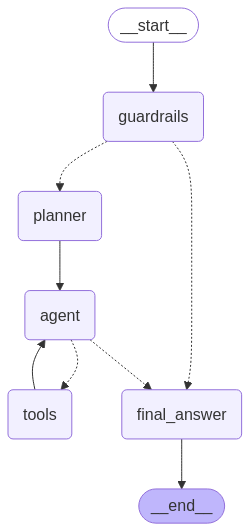

In [23]:
display(Image(graph.get_graph().draw_mermaid_png()))
# print(graph.get_graph().draw_ascii())

In [37]:
config_1 = {"configurable": {"thread_id": "1"}}
config_2 = {"configurable": {"thread_id": "2"}}
checkpointer = MemorySaver()

graph = graph_builder.compile(checkpointer=checkpointer)

In [49]:
result = graph.invoke({"input": HumanMessage("Hi ini testing ke-1")}, config_2)
display(result)

{'output': [HumanMessage(content='Hi ini testing ke-1', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[Agent]: OK', additional_kwargs={}, response_metadata={})],
 'steps_history': ['__start__',
  'guardrails',
  'planner',
  'agent',
  'final_answer',
  '__end__'],
 'llm_usage_metadata': [{'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
   'step': 'guardrails',
   'model': 'gemini-2.0-flash',
   'tokens': {'input_tokens': 2207,
    'output_tokens': 57,
    'total_tokens': 2264,
    'input_token_details': {'cache_read': 0}}},
  {'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
   'step': 'planner',
   'model': 'gemini-2.0-flash',
   'tokens': {'input_tokens': 2207,
    'output_tokens': 57,
    'total_tokens': 2264,
    'input_token_details': {'cache_read': 0}}},
  {'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
   'step': 'agent',
   'model': 'gemini-2.0-flash',
   'tokens': {'input_tokens': 2207,
    'output_tokens': 57,
    'total_tokens': 2264,
    'in

In [50]:
result = graph.invoke({"input": HumanMessage("Hi ini testing ke-2")}, config_2)
display(result)

{'output': [HumanMessage(content='Hi ini testing ke-2', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[Agent]: OK', additional_kwargs={}, response_metadata={})],
 'steps_history': ['__start__',
  'guardrails',
  'planner',
  'agent',
  'tools',
  'agent',
  'final_answer',
  '__end__'],
 'llm_usage_metadata': [{'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
   'step': 'guardrails',
   'model': 'gemini-2.0-flash',
   'tokens': {'input_tokens': 2207,
    'output_tokens': 57,
    'total_tokens': 2264,
    'input_token_details': {'cache_read': 0}}},
  {'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
   'step': 'planner',
   'model': 'gemini-2.0-flash',
   'tokens': {'input_tokens': 2207,
    'output_tokens': 57,
    'total_tokens': 2264,
    'input_token_details': {'cache_read': 0}}},
  {'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
   'step': 'agent',
   'model': 'gemini-2.0-flash',
   'tokens': {'input_tokens': 2207,
    'output_tokens': 57,
    'total_

In [51]:
result = graph.invoke({"input": HumanMessage("Halo ini testing ke-3")}, config_2)
display(result)

{'output': [HumanMessage(content='Halo ini testing ke-3', additional_kwargs={}, response_metadata={}),
  AIMessage(content='[Agent]: OK', additional_kwargs={}, response_metadata={})],
 'steps_history': ['__start__',
  'guardrails',
  'planner',
  'agent',
  'final_answer',
  '__end__'],
 'llm_usage_metadata': [{'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
   'step': 'guardrails',
   'model': 'gemini-2.0-flash',
   'tokens': {'input_tokens': 2207,
    'output_tokens': 57,
    'total_tokens': 2264,
    'input_token_details': {'cache_read': 0}}},
  {'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
   'step': 'planner',
   'model': 'gemini-2.0-flash',
   'tokens': {'input_tokens': 2207,
    'output_tokens': 57,
    'total_tokens': 2264,
    'input_token_details': {'cache_read': 0}}},
  {'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
   'step': 'agent',
   'model': 'gemini-2.0-flash',
   'tokens': {'input_tokens': 2207,
    'output_tokens': 57,
    'total_tokens': 2264,
    '

In [59]:
pprint(list(graph.get_state_history(config_2))[4]._asdict())

{'config': {'configurable': {'checkpoint_id': '1f014590-cd8c-6a21-800e-207a7cecc08f',
                             'checkpoint_ns': '',
                             'thread_id': '2'}},
 'created_at': '2025-04-08T09:08:34.866435+00:00',
 'metadata': {'parents': {},
              'source': 'loop',
              'step': 14,
              'thread_id': '2',
              'writes': None},
 'next': ('guardrails',),
 'parent_config': {'configurable': {'checkpoint_id': '1f014590-cd7c-61ff-800d-517f3aa2f17d',
                                    'checkpoint_ns': '',
                                    'thread_id': '2'}},
 'tasks': (PregelTask(id='b4c3cb9b-5270-6912-d9ca-9d6dd3e937e9', name='guardrails', path=('__pregel_pull', 'guardrails'), error=None, interrupts=(), state=None, result={'next_step': 'planner', 'messages': [HumanMessage(content='Halo ini testing ke-3', additional_kwargs={}, response_metadata={}), AIMessage(content='[Guardrails]: OK', additional_kwargs={}, response_metadata={})], '

In [24]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": ""}, config)

{'foo': 'b', 'bar': ['a', 'b']}

In [31]:
graph.get_state(config)._asdict()

{'values': {'foo': 'b', 'bar': ['a', 'b']},
 'next': (),
 'config': {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1f014541-3c13-6651-8002-d7709b1e36ad'}},
 'metadata': {'source': 'loop',
  'writes': {'node_b': {'foo': 'b', 'bar': ['b']}},
  'step': 2,
  'parents': {},
  'thread_id': '1'},
 'created_at': '2025-04-08T08:32:58.972321+00:00',
 'parent_config': {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1f014541-3c13-6650-8001-c19100603644'}},
 'tasks': ()}

In [123]:
for message in result["messages"]:
    message.pretty_print()

================================== Ai Message ==================================

[Guardrails]: OK
================================== Ai Message ==================================

[Planner]: OK
================================== Ai Message ==================================

[Agent]: OK
================================== Ai Message ==================================

[final_answer]: OK


In [124]:
for usage in result["llm_usage_metadata"]:
    pprint(usage)
    print()

{'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
 'model': 'gemini-2.0-flash',
 'step': 'guardrails',
 'tokens': {'input_token_details': {'cache_read': 0},
            'input_tokens': 2207,
            'output_tokens': 57,
            'total_tokens': 2264}}

{'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
 'model': 'gemini-2.0-flash',
 'step': 'guardrails',
 'tokens': {'input_token_details': {'cache_read': 0},
            'input_tokens': 2207,
            'output_tokens': 57,
            'total_tokens': 2264}}

{'id': 'run-2b100f1a-f169-47cd-b043-851d605b4264-0',
 'model': 'gemini-2.0-flash',
 'step': 'guardrails',
 'tokens': {'input_token_details': {'cache_read': 0},
            'input_tokens': 2207,
            'output_tokens': 57,
            'total_tokens': 2264}}

('final_answer',
 {'input_token_details': {'cache_read': 0},
  'input_tokens': 2207,
  'output_tokens': 57,
  'total_tokens': 2264})

